In [1]:
from common.torch_utils import get_available_device

device = get_available_device()

Platform: Darwin
Release: 21.5.0
MPS available: True
CUDA available: False
Selected device: mps


## Model

In [2]:
from fcos import FCOS
from fcos import build_backbone
from dataset import LabelsCodec

target_resolution = (256, 256)
model = FCOS(
    backbone=build_backbone('resnet50'),
    labels_codec=LabelsCodec(),
    res=target_resolution,
)

## Dataloader

In [3]:
from dataset.loader import build_dataloader

train_dataloader = build_dataloader('train', batch_size=4)
img, boxes, labels = next(iter(train_dataloader))
print(img.shape)
print(boxes)
print(labels)

torch.Size([4, 256, 256, 3])
[tensor([[175.1420,  33.7317, 256.0000, 155.3474],
        [145.2802, 134.6042, 256.0000, 256.0000],
        [  0.0000, 192.1951, 108.8879, 256.0000]]), tensor([[  0.0000,   0.0000, 213.3455, 256.0000]]), tensor([[  0.0000,   0.0000, 129.5036, 256.0000]]), tensor([[132.9672,  39.4320, 157.4209,  93.6760]])]
[tensor([2, 2, 2], dtype=torch.int32), tensor([3], dtype=torch.int32), tensor([1], dtype=torch.int32), tensor([9], dtype=torch.int32)]


/Users/iolkhovsky/Documents/repos/fcos/dataset/loader.py:59: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:233.)
  return torch.Tensor(images), bboxes, labels


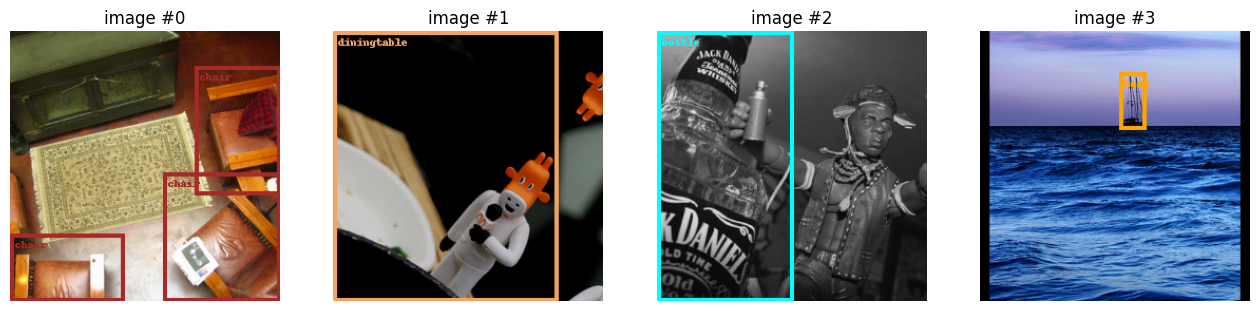

In [4]:
from dataset.visualization import visualize_batch
from dataset.labels_codec import LabelsCodec

visualize_batch(img, boxes, labels, codec=LabelsCodec())

In [5]:
pred = model(img)

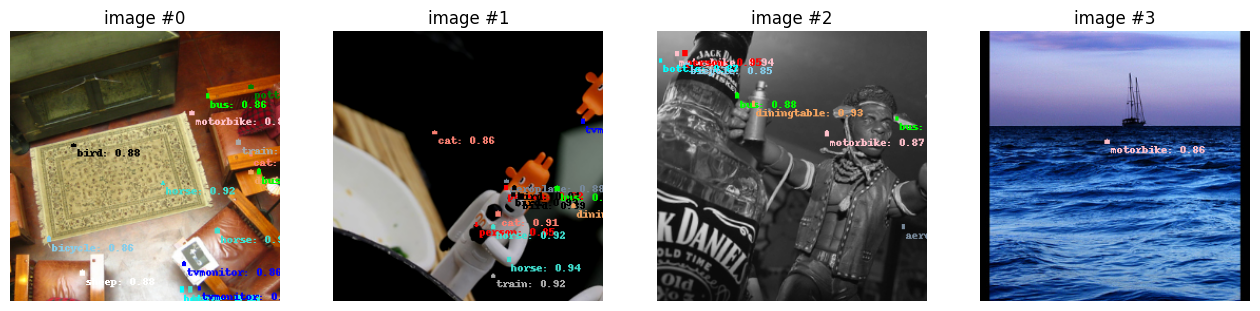

In [6]:
import torch


def draw_predictions(imgs_batch, prediction, labels_codec, threshold=0.01):  
    boxes = [[] for i in range(len(imgs_batch))]
    labels = [[] for i in range(len(imgs_batch))]
    scores = [[] for i in range(len(imgs_batch))]

    for fmap, map_pred in prediction.items():
        pred_classes = map_pred['classes']
        pred_center = map_pred['centerness']
        pred_boxes = map_pred['boxes']

        for img_idx in range(len(pred_classes)):
            img_classes = pred_classes[img_idx]
            img_centerness = pred_center[img_idx]
            img_boxes = pred_boxes[img_idx]
            
            final_scores = img_classes * img_centerness
            max_scores, max_indices = torch.max(final_scores, axis=1)
            mask = max_scores > threshold

            filtered_scores = max_scores[mask]
            filtered_labels = max_indices[mask]
            filtered_boxes = img_boxes[mask]
            
            for score, label, box in zip(filtered_scores, filtered_labels, filtered_boxes):
                scores[img_idx].append(score)
                labels[img_idx].append(label)
                boxes[img_idx].append(box)

    boxes = [
        torch.stack(img_boxes) if len(img_boxes) else torch.zeros((0, 4), dtype=torch.float)
        for img_boxes in boxes
    ]
    scores = [
        torch.stack(img_scores) if len(img_scores) else torch.zeros((0, 1), dtype=torch.float)
        for img_scores in scores
    ]  
    labels = [
        torch.stack(img_labels) if len(img_labels) else torch.zeros((0, 1), dtype=torch.float)
        for img_labels in labels
    ]

    visualize_batch(
        imgs_batch,
        boxes_batch=boxes,
        labels_batch=labels,
        scores_batch=scores,
        codec=labels_codec
    )
            


draw_predictions(img, pred, LabelsCodec(), 0.85)

## Loss function

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class FocalLoss(nn.Module):

    def __init__(self, alpha=0.25, gamma=2, apply_sigmoid=False):
        super(FocalLoss, self).__init__()
        self._alpha = alpha
        self._gamma = gamma
        self._apply_sigmoid = apply_sigmoid

    def forward(self, pred, target):
        if self._apply_sigmoid:
            pred = pred.sigmoid()
        ce = F.binary_cross_entropy(pred, target, reduction='none')
        alpha = target * self._alpha + (1. - target) * (1. - self._alpha)
        pt = torch.where(target == 1,  pred, 1 - pred)
        return alpha * (1. - pt) ** self._gamma * ce

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class CenternessLoss(nn.Module):

    def __init__(self):
        super(CenternessLoss, self).__init__()
        self._criterion = nn.BCELoss(reduction='none')

    def forward(self, pred, target):
        return self._criterion(pred, target)

In [61]:
class IoILoss(nn.Module):
    def __init__(self):
        super(IoILoss, self).__init__()

    def forward(self, pred, target):
        print(pred.shape, target.shape)
        
        pred_l, target_l = pred[:, 0], target[:, 0]
        pred_t, target_t = pred[:, 1], target[:, 1]
        pred_r, target_r = pred[:, 2], target[:, 2]
        pred_b, target_b = pred[:, 3], target[:, 3]
        
        intersection_l = torch.max(-1 * pred_l, -1 * target_l)
        intersection_t = torch.max(-1 * pred_t, -1 * target_t)
        intersection_r = torch.min(pred_r, target_r)
        intersection_b = torch.min(pred_b, target_b)
        
        zero_mask = torch.logical_or(
            intersection_r <= intersection_l,
            intersection_b <= intersection_t,
        )
        
        intersection = (intersection_r - intersection_l) * (intersection_b - intersection_t)
        predArea = (pred_r - pred_l) * (pred_b - pred_t)
        targetArea = (target_r - target_l) * (target_b - target_t)
        union = predArea + targetArea - intersection
        
        iou = intersection / (union + 1e-6)
        
        iou[zero_mask] = 0.
        loss = 1. - iou
        print(loss.shape)
        return loss

In [62]:
import torchvision
from fcos import FcosDetectionsCodec


def total_loss(pred, target):
    # targets
    target_classes, target_centerness, target_boxes = target
    all_fmaps = list(target_classes.keys())
    
    first_map = all_fmaps[0]

    b, c, h, w = target_classes[first_map].shape
    target_classes = torch.cat(
        [
            torch.reshape(torch.permute(v, [0, 2, 3, 1]), [b, -1, c]) for k, v in target_classes.items()
        ],
        axis=1
    )

    b, c, h, w = target_centerness[first_map].shape
    target_centerness = torch.cat(
        [
            torch.reshape(torch.permute(v, [0, 2, 3, 1]), [b, -1, c]) for k, v in target_centerness.items()
        ],
        axis=1
    )

    b, c, h, w = target_boxes[first_map].shape
    target_boxes = torch.cat(
        [
            torch.reshape(torch.permute(v, [0, 2, 3, 1]), [b, -1, c]) for k, v in target_boxes.items()
        ],
        axis=1
    )

    # prediction
    pred_classes = torch.cat(
        [
            pred[map_name]['classes'] for map_name in all_fmaps
        ],
        axis=1
    )

    pred_centerness = torch.cat(
        [
            pred[map_name]['centerness'] for map_name in all_fmaps
        ],
        axis=1
    )

    pred_boxes = torch.cat(
        [
            pred[map_name]['boxes'] for map_name in all_fmaps
        ],
        axis=1
    )

    # loss
    print(f"Classes (pred / target): {pred_classes.shape} {target_classes.shape}")
    print(f"Centerness (pred / target): {pred_centerness.shape} {target_centerness.shape}")
    print(f"Boxes (pred / target): {pred_boxes.shape} {target_boxes.shape}")
    
    positive_samples = torch.sum(target_classes, axis=-1)  
    positive_mask = positive_samples > 0
    positive_samples_cnt = torch.sum(positive_mask)
    print("Positive samples cnt:", positive_samples_cnt)
    
    fl_criterion = FocalLoss()
    class_loss = fl_criterion(
        pred_classes,
        target_classes
    )
    class_loss = torch.sum(class_loss) / positive_samples_cnt

    cntr_criterion = CenternessLoss()
    centerness_loss = cntr_criterion(pred_centerness, target_centerness)
    centerness_loss = torch.sum(centerness_loss) / positive_samples_cnt

    pred_boxes_positive = torch.reshape(pred_boxes[positive_mask], [-1, 4])
    target_boxes_positive = torch.reshape(target_boxes[positive_mask], [-1, 4])

    regr_criterion = IoILoss()
    regression_loss = regr_criterion(
        pred_boxes_positive,
        target_boxes_positive,
    )
    regression_loss = torch.sum(regression_loss)

    return class_loss, centerness_loss, regression_loss
    

img_res = (256, 256)
labels_codec = LabelsCodec()
codec = FcosDetectionsCodec(img_res, labels_codec)

targets = codec.encode(boxes, labels)
res = total_loss(pred, targets)
print("Loss", res)

Classes (pred / target): torch.Size([4, 1364, 20]) torch.Size([4, 1364, 20])
Centerness (pred / target): torch.Size([4, 1364, 1]) torch.Size([4, 1364, 1])
Boxes (pred / target): torch.Size([4, 1364, 4]) torch.Size([4, 1364, 4])
Positive samples cnt: tensor(95)
torch.Size([95, 4]) torch.Size([95, 4])
torch.Size([95])
Loss (tensor(297.1697, grad_fn=<DivBackward0>), tensor(45.6010, grad_fn=<DivBackward0>), tensor(-1.2288e+10, grad_fn=<SumBackward0>))


## Training draft

In [63]:
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = total_loss

In [65]:
for epoch in range(1):

    for step, (img, boxes, labels) in enumerate(train_dataloader):
    
        optimizer.zero_grad()

        pred = model(img)
        targets = codec.encode(boxes, labels)
        clf_loss, cntr_loss, regr_loss = criterion(pred, targets)
        total_loss = clf_loss + cntr_loss + regr_loss
        print(f"Step {step} Total loss: {total_loss}")
        print(f"\tClassification: {clf_loss}")
        print(f"\tCenterness {cntr_loss}")
        print(f"\tRegression {regr_loss}")
        print()
        total_loss.backward()
        optimizer.step()

print('Finished Training')

Classes (pred / target): torch.Size([4, 1364, 20]) torch.Size([4, 1364, 20])
Centerness (pred / target): torch.Size([4, 1364, 1]) torch.Size([4, 1364, 1])
Boxes (pred / target): torch.Size([4, 1364, 4]) torch.Size([4, 1364, 4])
Positive samples cnt: tensor(105)
torch.Size([105, 4]) torch.Size([105, 4])
torch.Size([105])
Step 0 Total loss: nan
	Classification: 268.7964172363281
	Centerness nan
	Regression 237.9567413330078

Classes (pred / target): torch.Size([4, 1364, 20]) torch.Size([4, 1364, 20])
Centerness (pred / target): torch.Size([4, 1364, 1]) torch.Size([4, 1364, 1])
Boxes (pred / target): torch.Size([4, 1364, 4]) torch.Size([4, 1364, 4])
Positive samples cnt: tensor(73)


RuntimeError: all elements of input should be between 0 and 1